# Team & Innings Insights

Key questions addressed in this analysis:

1. How are runs scored and wickets lost across different phases of a two-day innings (Early: 1–10, Middle: 11–40, Late: 41+) when analysing multiple matches?
2. How frequently do wicket collapses occur, during which innings phases do they arise, and how severe are these collapse periods?
3. How does batting partnership contribution vary by wicket number across innings?

## Data preparation

In [2]:
import glob
import pandas as pd

files = sorted(glob.glob("../data/raw/*.csv"))
files, len(files)

(['../data/raw/2025-10-25-ball-by-ball.csv',
  '../data/raw/2025-11-08-ball-by-ball.csv',
  '../data/raw/2025-11-23-ball-by-ball.csv',
  '../data/raw/2025-12-13-ball-by-ball.csv',
  '../data/raw/2026-01-10-ball-by-ball.csv',
  '../data/raw/2026-01-25-ball-by-ball.csv'],
 6)

In [3]:
dfs = []

for i, path in enumerate(files, start=1):
    temp = pd.read_csv(path)
    temp.columns = temp.columns.str.lower().str.strip()
    temp["match_id"] = i
    temp["source_file"] = path.split("/")[-1]
    dfs.append(temp)

df = pd.concat(dfs, ignore_index=True)

df.shape

(5141, 6)

In [4]:
df.columns

Index(['ball', 'score', 'outcome', 'innings', 'match_id', 'source_file'], dtype='str')

In [5]:
df["over"] = df["ball"].astype(str).str.split(".").str[0].astype(int)
df["ball_in_over"] = df["ball"].astype(str).str.split(".").str[1].astype(int)

df[["ball", "over", "ball_in_over"]].head(10)

,ball,over,ball_in_over
0,60.5,60,5
1,60.4,60,4
2,60.3,60,3
3,60.2,60,2
4,60.1,60,1
5,59.7,59,7
6,59.6,59,6
7,59.5,59,5
8,59.4,59,4
9,59.3,59,3


In [6]:
score_split = (
    df["score"]
      .astype(str)
      .str.replace("--", "-", regex=False)
      .str.split("-", expand=True)
)

df["cum_wickets"] = score_split[0].astype(int)
df["cum_runs"] = score_split[1].astype(int)

df[["score", "cum_wickets", "cum_runs"]].head(10)

,score,cum_wickets,cum_runs
0,8--160,8,160
1,8--160,8,160
2,8--160,8,160
3,8--160,8,160
4,8--160,8,160
5,8--160,8,160
6,8--160,8,160
7,8--160,8,160
8,8--159,8,159
9,8--159,8,159


In [7]:
df = df.sort_values(
    ["match_id", "innings", "over", "ball_in_over"],
    ascending=True
).reset_index(drop=True)

In [8]:
df["runs_off_ball"] = (
    df.groupby(["match_id", "innings"])["cum_runs"]
      .diff()
      .fillna(0)
      .astype(int)
)

df["is_wicket"] = (
    df.groupby(["match_id", "innings"])["cum_wickets"]
      .diff()
      .fillna(0)
      .astype(int)
      .clip(0, 1)
)

df[["ball", "score", "runs_off_ball", "is_wicket"]].head(15)

,ball,score,runs_off_ball,is_wicket
0,0.1,0--0,0,0
1,0.2,0--4,4,0
2,0.3,0--8,4,0
3,0.4,0--8,0,0
4,0.5,0--12,4,0
5,0.6,0--12,0,0
6,1.1,0--12,0,0
7,1.2,0--14,2,0
8,1.3,0--14,0,0
9,1.4,0--14,0,0


In [9]:
def innings_phase(over):
    if over <= 10:
        return "Early (1–10)"
    elif over <= 40:
        return "Middle (11–40)"
    else:
        return "Late (41+)"

df["innings_phase"] = df["over"].apply(innings_phase)
df[["over", "innings_phase"]].head(20)

,over,innings_phase
0,0,Early (1–10)
1,0,Early (1–10)
2,0,Early (1–10)
3,0,Early (1–10)
4,0,Early (1–10)
5,0,Early (1–10)
6,1,Early (1–10)
7,1,Early (1–10)
8,1,Early (1–10)
9,1,Early (1–10)


In [10]:
pacc_df = df[df["innings"].str.contains("Port Adelaide", case=False)]
pacc_df["ball_no"] = pacc_df["over"] * 6 + pacc_df["ball_in_over"]
pacc_df = pacc_df.sort_values(["match_id", "innings", "ball_no"]).reset_index(drop=True)

In [11]:
pacc_df.head()

,ball,score,outcome,innings,match_id,source_file,over,ball_in_over,cum_wickets,cum_runs,runs_off_ball,is_wicket,innings_phase,ball_no
0,0.1,0--0,A Stockdale to N Fernandes : No Run,1st Innings - Port Adelaide,1,2025-10-25-ball-by-ball.csv,0,1,0,0,0,0,Early (1–10),1
1,0.2,0--2,A Stockdale to N Fernandes : 2 runs,1st Innings - Port Adelaide,1,2025-10-25-ball-by-ball.csv,0,2,0,2,2,0,Early (1–10),2
2,0.3,0--2,A Stockdale to N Fernandes : No Run,1st Innings - Port Adelaide,1,2025-10-25-ball-by-ball.csv,0,3,0,2,0,0,Early (1–10),3
3,0.4,0--2,A Stockdale to N Fernandes : No Run,1st Innings - Port Adelaide,1,2025-10-25-ball-by-ball.csv,0,4,0,2,0,0,Early (1–10),4
4,0.5,0--2,A Stockdale to N Fernandes : No Run,1st Innings - Port Adelaide,1,2025-10-25-ball-by-ball.csv,0,5,0,2,0,0,Early (1–10),5


## Run Rate and wickets by Innings Phase

In [12]:
per_innings_phase = (
    pacc_df.groupby(["match_id", "innings", "innings_phase"])
      .agg(
          runs=("runs_off_ball", "sum"),
          wickets=("is_wicket", "sum"),
          balls=("ball", "count")
      )
      .reset_index()
)

per_innings_phase["overs"] = per_innings_phase["balls"] / 6
per_innings_phase["run_rate"] = per_innings_phase["runs"] / per_innings_phase["overs"]

summary = (
    per_innings_phase.groupby("innings_phase")
      .agg(
          avg_run_rate=("run_rate", "mean"),
          avg_wickets=("wickets", "mean"),
          innings_count=("run_rate", "count")
      )
      .reset_index()
)

summary

,innings_phase,avg_run_rate,avg_wickets,innings_count
0,Early (1–10),3.209269,1.000000,7
1,Late (41+),4.016841,4.600000,5
2,Middle (11–40),3.741757,4.285714,7


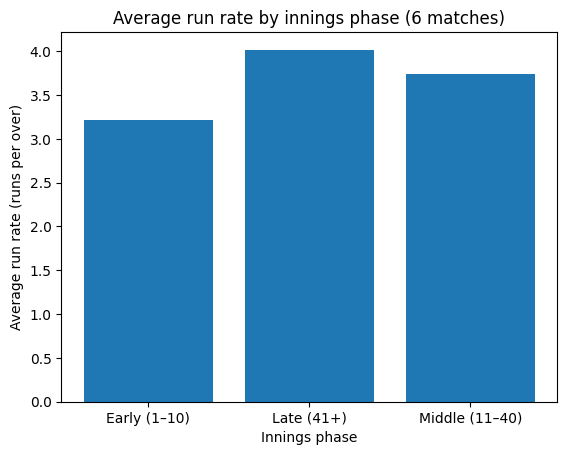

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(summary["innings_phase"], summary["avg_run_rate"])
plt.ylabel("Average run rate (runs per over)")
plt.xlabel("Innings phase")
plt.title("Average run rate by innings phase (6 matches)")
plt.show()

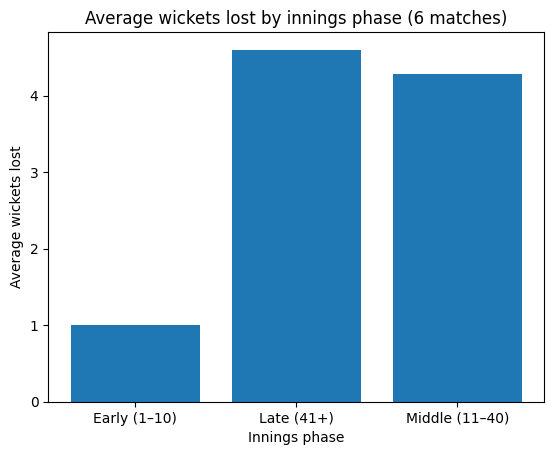

In [14]:
plt.figure()
plt.bar(summary["innings_phase"], summary["avg_wickets"])
plt.ylabel("Average wickets lost")
plt.xlabel("Innings phase")
plt.title("Average wickets lost by innings phase (6 matches)")
plt.show()

## Wicket Collapse Frequency

A collapse is defined as two or more wickets falling within a 15-ball window.
This metric captures periods of rapid loss of wickets rather than isolated dismissals.

In [15]:
WINDOW = 15
THRESH = 2

pacc_df["wickets_last_15"] = (
    pacc_df.groupby(["match_id", "innings"])["is_wicket"]
           .rolling(window=WINDOW, min_periods=WINDOW)
           .sum()
           .reset_index(level=[0,1], drop=True)
)

pacc_df["collapse_flag"] = pacc_df["wickets_last_15"] >= THRESH

# collapse occurrence per innings
collapse_by_innings = (
    pacc_df.groupby(["match_id", "innings"])["collapse_flag"]
           .any()
           .reset_index(name="collapse_occurred")
)

collapse_by_innings["collapse_occurred"].value_counts(normalize=True)

collapse_occurred
True     0.857143
False    0.142857
Name: proportion, dtype: float64

In [16]:
collapse_summary = (
    collapse_by_innings["collapse_occurred"]
    .value_counts()
    .rename_axis("collapse_occurred")
    .reset_index(name="innings_count")
)
collapse_summary

,collapse_occurred,innings_count
0,True,6
1,False,1


In [17]:
collapse_timing = (
    pacc_df[pacc_df["collapse_flag"]]
    .groupby("innings_phase")
    .size()
    .reset_index(name="collapse_events")
)

collapse_timing

,innings_phase,collapse_events
0,Late (41+),27
1,Middle (11–40),66


## Collapse Severity

Collapse severity is measured as the maximum number of wickets lost within any
15-ball window during an innings.

Most collapse periods involve the loss of two wickets, while more severe collapses
(three or more wickets in a short span) occur less frequently. This suggests that
instability is usually brief, but can occasionally escalate into more damaging phases.

In [18]:
# Collapse severity per innings
collapse_severity = (
    pacc_df.groupby(["match_id", "innings"])["wickets_last_15"]
    .max()
    .reset_index(name="max_wickets_in_15")
)

collapse_severity.describe()

,match_id,max_wickets_in_15
count,7.000000,7.000000
mean,3.714286,1.857143
std,1.799471,0.377964
min,1.000000,1.000000
25%,2.500000,2.000000
50%,4.000000,2.000000
75%,5.000000,2.000000
max,6.000000,2.000000


## Partnership Contribution by Wicket Number

This section analyses batting partnerships at the team level by measuring the
number of runs scored between successive wickets (e.g. opening partnership,
second-wicket partnership, etc.).

Partnerships are defined using wicket numbers rather than batter identities,
as non-striker information is not available in the source data.

In [19]:
pacc_df = pacc_df.sort_values(
    ["match_id", "innings", "ball_no"]
).reset_index(drop=True)

In [24]:
# Start-of-innings rows
starts = (
    pacc_df.groupby(["match_id", "innings"], as_index=False)
     .first()[["match_id", "innings"]]
)
starts["cum_wickets"] = 0
starts["cum_runs"] = 0

# Rows where wickets fell (take the first ball where cum_wickets becomes 1,2,3,...)
wicket_falls = (
    pacc_df[pacc_df["is_wicket"] == 1]
    .groupby(["match_id", "innings", "cum_wickets"], as_index=False)
    .first()[["match_id", "innings", "cum_wickets", "cum_runs"]]
)

# Combine and sort
wicket_points = (
    pd.concat([starts, wicket_falls], ignore_index=True)
      .sort_values(["match_id", "innings", "cum_wickets"])
      .reset_index(drop=True)
)

wicket_points.head()

,match_id,innings,cum_wickets,cum_runs
0,1,1st Innings - Port Adelaide,0,0
1,1,1st Innings - Port Adelaide,1,35
2,1,1st Innings - Port Adelaide,2,78
3,1,1st Innings - Port Adelaide,3,109
4,1,1st Innings - Port Adelaide,4,147


In [25]:
wicket_points["partnership_runs"] = (
    wicket_points.groupby(["match_id", "innings"])["cum_runs"].diff()
)

# Wicket number labels: 1st wicket partnership, 2nd wicket partnership, etc.
wicket_points["wicket_number"] = wicket_points["cum_wickets"]

partnerships = wicket_points.dropna(subset=["partnership_runs"]).copy()
partnerships.head()

,match_id,innings,cum_wickets,cum_runs,partnership_runs,wicket_number
1,1,1st Innings - Port Adelaide,1,35,35.0,1
2,1,1st Innings - Port Adelaide,2,78,43.0,2
3,1,1st Innings - Port Adelaide,3,109,31.0,3
4,1,1st Innings - Port Adelaide,4,147,38.0,4
5,1,1st Innings - Port Adelaide,5,191,44.0,5


In [26]:
partnership_summary = (
    partnerships.groupby("wicket_number")
      .agg(
          innings_count=("partnership_runs", "count"),
          mean_runs=("partnership_runs", "mean"),
          median_runs=("partnership_runs", "median")
      )
      .reset_index()
      .sort_values("wicket_number")
)

partnership_summary

,wicket_number,innings_count,mean_runs,median_runs
0,1,7,30.714286,35.0
1,2,7,30.000000,27.0
2,3,7,37.571429,31.0
3,4,7,24.285714,8.0
4,5,7,15.857143,5.0
5,6,6,18.166667,10.5
6,7,6,23.833333,20.5
7,8,5,33.200000,22.0
8,9,5,11.000000,12.0
9,10,3,18.000000,6.0


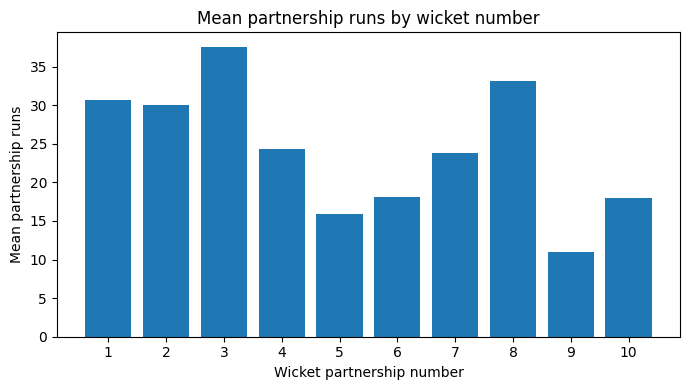

In [28]:
plt.figure(figsize=(7,4))
plt.bar(partnership_summary["wicket_number"], partnership_summary["mean_runs"])
plt.xlabel("Wicket partnership number")
plt.ylabel("Mean partnership runs")
plt.title("Mean partnership runs by wicket number")
plt.xticks(partnership_summary["wicket_number"])
plt.tight_layout()
plt.show()